#  Ultrasound Image Deconvolution  
### Tikhonov Regularization vs. DDRM (Denoising Diffusion Restoration Models)

### Prabir Kumar DAS

This notebook compares classical **Tikhonov deconvolution** with the modern deep learning-based **DDRM** approach for ultrasound image restoration.  
We analyze both methods in terms of visual quality and quantitative metrics such as **SNR**, **CNR**, **TCR**, and **FWHM-based resolution gain**.


### Loading RF data

In [73]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/invivo/psf_estim_vivo.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'psf_estim_vivo'])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# Load the data
data = scipy.io.loadmat('exp/datasets/NewVivoData/newData.mat')
rf = data['matImage'].astype(np.float64)
print('RF shape:', rf.shape)
print('RF range: min =', np.min(rf), ', max =', np.max(rf))

RF shape: (832, 299)
RF range: min = -8192.0 , max = 5741.0


(512, 299)


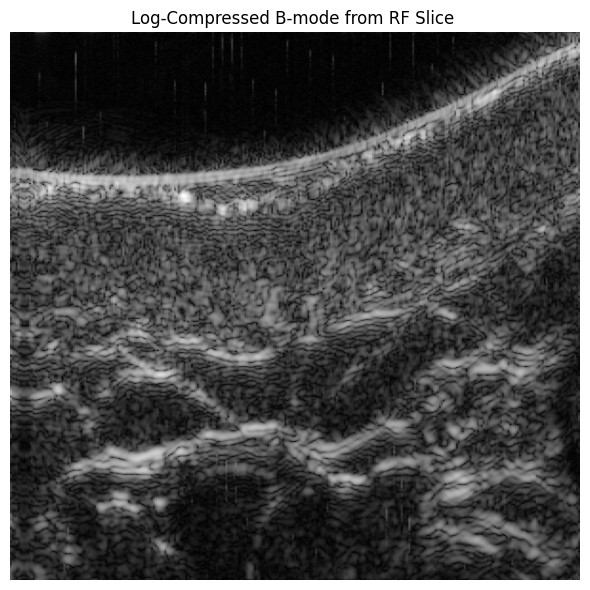

In [3]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load the .mat file
carotid_data = scipy.io.loadmat('exp/datasets/NewVivoData/newData.mat')
rf_data = carotid_data['matImage']

# Log compression baseline
LogB = 100

# Extract 512 rows starting from index 1000
rf_section = rf_data[5:5+512, :]

print(rf_section.shape)

# Apply Hilbert transform along depth axis
env = np.abs(hilbert(rf_section, axis=0))

# Log compression
log_env = np.log(env + LogB)

# Plot B-mode image
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('Log-Compressed B-mode from RF Slice ')
plt.axis('off')
plt.tight_layout()
plt.show()

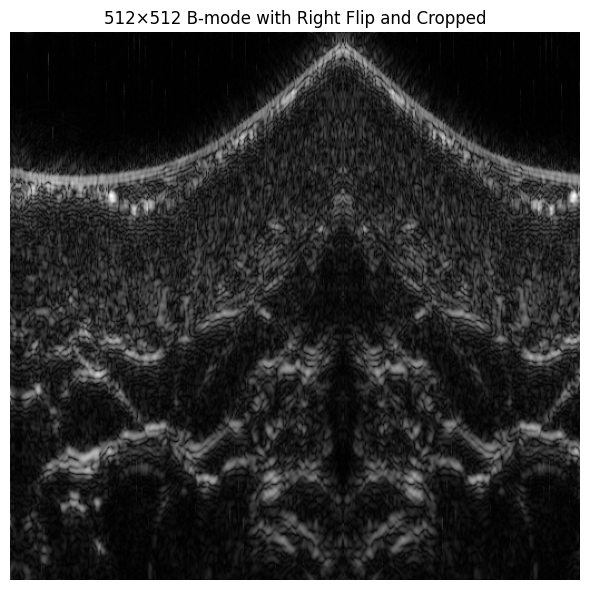

In [4]:
H, W = rf_section.shape

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 500
env = np.abs(hilbert(rf_filled, axis=0))
log_env = np.log(env + LogB)

# Plot the final 512×512 result
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode with Right Flip and Cropped')
plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
rf_filled.shape

(512, 512)

In [6]:
print('RF range: min =', np.min(rf_filled), ', max =', np.max(rf_filled))

RF range: min = -8192 , max = 5741


In [7]:
rfn = rf_filled / np.max(np.abs(rf_filled))
print('RF range: min =', np.min(rfn), ', max =', np.max(rfn))

RF range: min = -1.0 , max = 0.7008056640625


In [8]:
import scipy.io

# Save only the 512×512 RF matrix
scipy.io.savemat('exp/datasets/NewVivoData/rf_ddrm.mat', {'data': rf_filled})
scipy.io.savemat('exp/datasets/NewVivoData/rfn_ddrm.mat', {'data': rfn})

### Loading and Visualize PSF

In [9]:
# Load the estimated PSF from the uploaded psf.mat file
psf_mat_path = 'exp/datasets/NewVivoData/PSF_crop.mat'
psf_data = scipy.io.loadmat(psf_mat_path)

# List keys to identify the PSF variable
psf_data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'cropped_psf'])

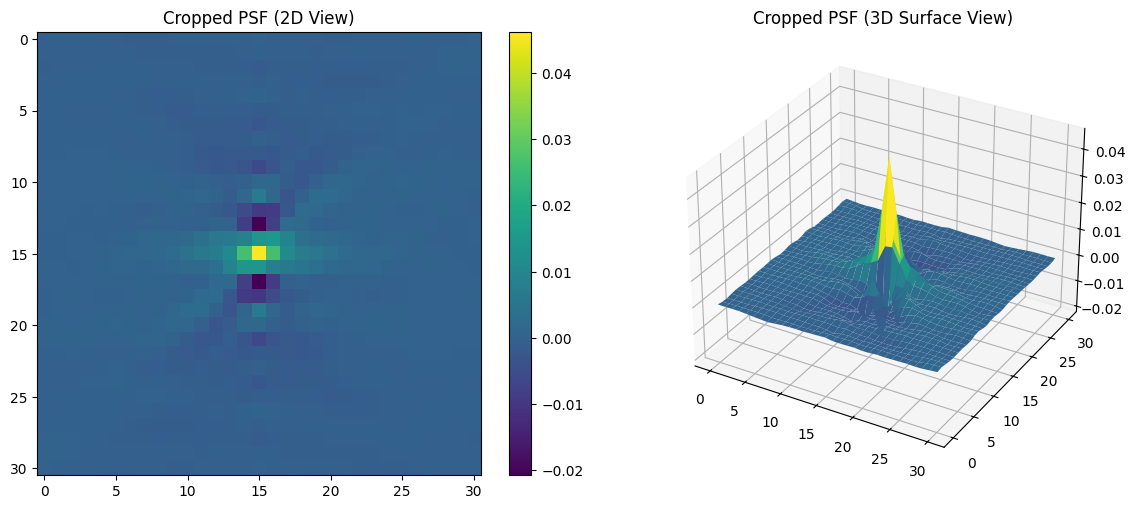

In [10]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cropped PSF from the uploaded .mat file
mat = scipy.io.loadmat('exp/datasets/NewVivoData/PSF_crop.mat')
cropped_psf = mat['cropped_psf']

# Plot the 2D image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_psf, cmap='viridis')
plt.title('Cropped PSF (2D View)')
plt.axis('image')
plt.colorbar()

# Plot the 3D surface
ax = plt.subplot(1, 2, 2, projection='3d')
x = np.arange(cropped_psf.shape[1])
y = np.arange(cropped_psf.shape[0])
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, cropped_psf, cmap='viridis', edgecolor='none')
ax.set_title('Cropped PSF (3D Surface View)')

plt.tight_layout()
plt.show()


### Noise Estimation using wavelet Decomposition

In [11]:
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
import numpy as np
import scipy.io
import pywt

# Load the RF data
mat = scipy.io.loadmat('exp/datasets/NewVivoData/newData.mat')
rf = mat['matImage'].astype(np.float64)

# Perform a 2D wavelet decomposition at the finest scale (level=1)
wavelet = 'db1'  # Daubechies 1 wavelet (Haar)
coeffs = pywt.wavedec2(rf, wavelet, level=1)

# Extract detail coefficients: horizontal, vertical, and diagonal
cH, cV, cD = coeffs[1]

# Flatten and concatenate all detail coefficients
detail_coeffs = np.concatenate([cH.ravel(), cV.ravel(), cD.ravel()])

# Median Absolute Deviation (MAD)-based noise estimation
median_val = np.median(np.abs(detail_coeffs))
sigma_est = median_val / 0.023

# Convert estimated noise to decibels
sigma_db = 20 * np.log10(sigma_est)

sigma_est, sigma_db

# Print the result in a formatted string
print(f"Estimated noise standard deviation (σ): {sigma_est:.2f}")
print(f"Estimated noise level in decibels (dB): {sigma_db:.2f} dB")


Estimated noise standard deviation (σ): 1000.00
Estimated noise level in decibels (dB): 60.00 dB


In [15]:
print(median_val)

23.000000000000004


### Tikhonov Deconvolution

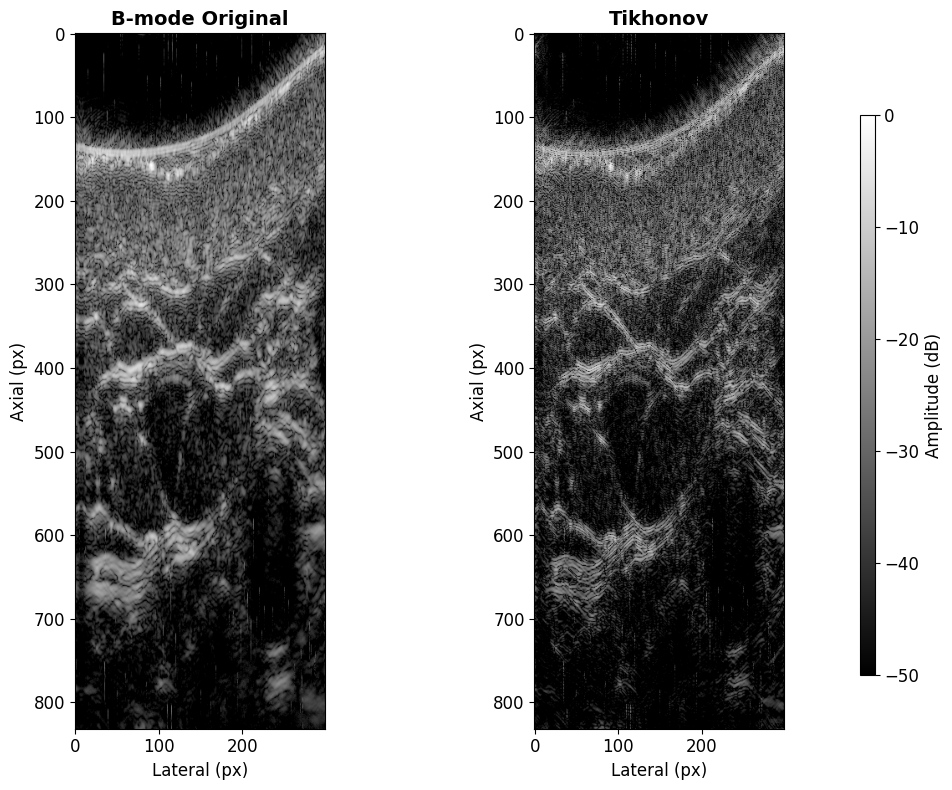

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, correlate
import warnings
warnings.filterwarnings('ignore')

# 1. Load raw RF data
data = loadmat('exp/datasets/NewVivoData/newData.mat')
rf = data['matImage']
rfn = rf / np.max(np.abs(rf))  # normalized RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/NewVivoData/PSF_crop.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh])/2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 500  # ~60 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# 3. Envelope detection and log compression
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# Raw data processing
env_raw = np.abs(hilbert(rf, axis=0))
env_raw = env_raw / np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)
bmode_raw = np.maximum(bmode_raw, -50)

# Tikhonov processing
env_tikh = np.abs(VivoTK)
env_tikh = env_tikh / np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)
bmode_tikh = np.maximum(bmode_tikh, -50)



# 5. Visualization
fig = plt.figure(figsize=(10, 8))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Original', 'Tikhonov']
images = [bmode_raw, bmode_tikh]

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (dB)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
# 🔹 Save figure as PDF (high resolution)
plt.savefig("exp/image_samples/NewVivoFinal/Tikhonv/TikhonovBmode_Comparison.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
from scipy.io import savemat
savemat('exp/datasets/NewVivoData/VivoTK.mat', {'VivoTK': VivoTK})


In [17]:
# Save the figure
output_path = "exp/image_samples/NewVivoFinal/bmode_original_Tikhonov.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')

# DDRM 

In [69]:
folder_name = "NewVivoFinal/NewVivo_it50sigma25"

In [70]:
!python main.py --ni --config deblur_newVivo.yml --doc imagenet_ood --timesteps 50 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 25 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-08-29 20:44:08,806 - Using device: cuda
INFO - main.py - 2025-08-29 20:44:08,808 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-08-29 20:44:08,808 - Exp instance id = 979735
INFO - main.py - 2025-08-29 20:44:08,808 - Exp comment = 
building dataset from exp/NewVivoData.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [0

RF raw range:       min = -1.0000, max = 0.7008
Tikhonov range:     min = -1.0000, max = 0.8193
DDRM range:         min = -0.9623, max = 0.5349


/tmp/ipykernel_971744/849628681.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


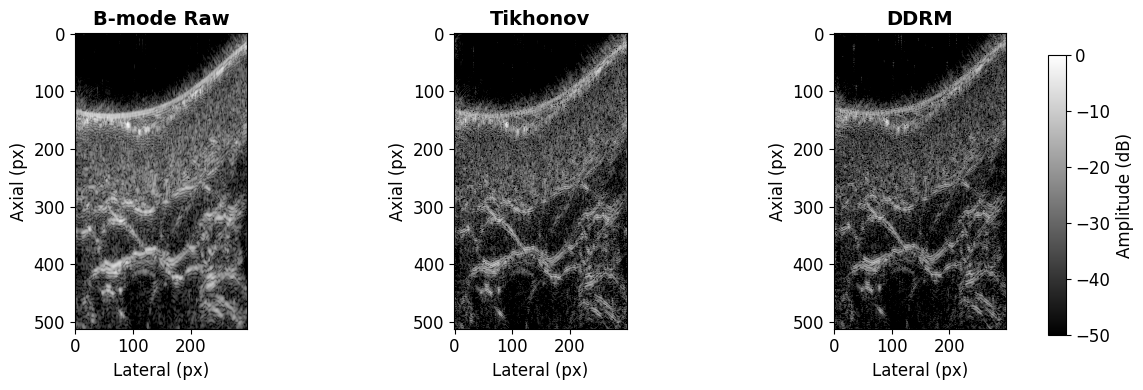

Saved: exp/image_samples/NewVivoFinal/NewVivo_it50sigma25/Bmode_Comparison.pdf


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# 1. Load raw RF data
data = loadmat('exp/datasets/NewVivoData/newData.mat')
rf = data['matImage']
rfn = rf / np.max(np.abs(rf))  # Normalize RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/NewVivoData/PSF_crop.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))

Mh, Nh = h.shape
Mrf, Nrf = rf.shape
center = np.round([Mh, Nh]) / 2

# Create BCCB degradation operator
pad_h = np.pad(h, ((0, Mrf - Mh), (0, Nrf - Nh)), mode='constant')
pad_h = np.roll(pad_h, int(1 - center[0]), axis=0)
pad_h = np.roll(pad_h, int(1 - center[1]), axis=1)
D = np.fft.fft2(pad_h)

SNR_val = 500  # ~30 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (1/SNR_val + np.conj(D)*D))
VivoTK = np.real(VivoTK)
VivoTK /= np.max(np.abs(VivoTK))

# 3. DDRM restoration
#ddrm_data = loadmat('exp/image_samples/NewVivoFinal/NewVivo_it50sigma40/0_-1.mat')
ddrm_data = loadmat(f"exp/image_samples/{folder_name}/0_-1.mat")

image = ddrm_data['image']
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4. Envelope detection and log compression
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
M, N = min(M1, M2, M3), min(N1, N2, N3)

# Crop to common size
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]
grayimage = grayimage[:M, :N]

# Envelope + Log Compression
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)

env_tikh = np.abs(VivoTK)
env_tikh /= np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)

env_ddrm = np.abs(grayimage)
env_ddrm /= np.max(env_ddrm)
bmode_ddrm = 20 * np.log10(env_ddrm + np.finfo(float).eps)

# 5. Print statistics
print(f'RF raw range:       min = {np.min(rfn):.4f}, max = {np.max(rfn):.4f}')
print(f'Tikhonov range:     min = {np.min(VivoTK):.4f}, max = {np.max(VivoTK):.4f}')
print(f'DDRM range:         min = {np.min(grayimage):.4f}, max = {np.max(grayimage):.4f}')

# 6. Simplified B-mode Visualization (Only 3 Results + Shared Colorbar + Axial Resolution Labels)
fig = plt.figure(figsize=(12,4))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Raw', 'Tikhonov', 'DDRM']
images = [bmode_raw, bmode_tikh, bmode_ddrm]

# Plot all three B-mode results
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)
    
    # Add axial resolution annotation (bottom-left corner)


# Add unified colorbar
plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (dB)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

#plt.suptitle('Ultrasound B-mode Comparison with Resolution', fontsize=16, fontweight='bold')
plt.tight_layout()
# --- Save as lossless (vector) PDF ---
#fig.savefig("Bmode_Comparison.pdf", bbox_inches="tight")  # axes/text stay vector; images embedded losslessly
plt.show()

import os
save_dir = os.path.join("exp", "image_samples", folder_name)
os.makedirs(save_dir, exist_ok=True)
out_pdf = os.path.join(save_dir, "Bmode_Comparison.pdf")
fig.savefig(out_pdf, bbox_inches="tight")  # vector PDF; images embedded losslessly
print("Saved:", out_pdf)

In [20]:
import os
save_dir = os.path.join("exp", "image_samples", folder_name)
os.makedirs(save_dir, exist_ok=True)
out_pdf = os.path.join(save_dir, "Bmode_Comparison.pdf")
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved:", out_pdf)


Saved: exp/image_samples/NewVivoFinal/NewVivo_it20sigma10/Bmode_Comparison.pdf


In [24]:
# Save the figure
output_path = "exp/image_samples/NewVivo_final/comparison.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [22]:
print('RF raw range: min =', np.min(rfn), ', max =', np.max(rfn))
print('Tikhonov range: min =', np.min(VivoTK), ', max =', np.max(VivoTK))
print('DDRM range: min =', np.min(grayimage), ', max =', np.max(grayimage))

RF raw range: min = -1.0 , max = 0.7008056640625
Tikhonov range: min = -1.0 , max = 0.8192913092614004
DDRM range: min = -1.0 , max = 0.67005605


In [19]:
print('RF raw range: min =', np.min(rf), ', max =', np.max(rf))
print('Tikhonov range: min =', np.min(VivoTK), ', max =', np.max(VivoTK))
print('DDRM range: min =', np.min(grayimage), ', max =', np.max(grayimage))

RF raw range: min = -8192 , max = 5741
Tikhonov range: min = -1.0 , max = 0.8192913092614004
DDRM range: min = -1.0 , max = 0.66418576


### Metrics Calculation: 